In [7]:
%pip install -r requirements.txt
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import tarfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path

Note: you may need to restart the kernel to use updated packages.


In [2]:
pd.set_option("display.max_rows", 200)

In [3]:
tsv_file = "data/data-tcga/clinical.tsv"
clinical_df = dataframe = pd.read_csv(tsv_file, delimiter='\t')

# Remove duplicate rows based on 'case_id' column
print(f'Shape before deduplication: {clinical_df.shape}')
clinical_df = clinical_df.drop_duplicates(subset='case_id', keep='first')
print(f'Shape after deduplication: {clinical_df.shape}')

print(clinical_df.columns.values)

Shape before deduplication: (14383, 158)
Shape after deduplication: (7419, 158)
['case_id' 'case_submitter_id' 'project_id' 'age_at_index'
 'age_is_obfuscated' 'cause_of_death' 'cause_of_death_source'
 'country_of_residence_at_enrollment' 'days_to_birth' 'days_to_death'
 'ethnicity' 'gender' 'occupation_duration_years' 'premature_at_birth'
 'race' 'vital_status' 'weeks_gestation_at_birth' 'year_of_birth'
 'year_of_death' 'adrenal_hormone' 'age_at_diagnosis' 'ajcc_clinical_m'
 'ajcc_clinical_n' 'ajcc_clinical_stage' 'ajcc_clinical_t'
 'ajcc_pathologic_m' 'ajcc_pathologic_n' 'ajcc_pathologic_stage'
 'ajcc_pathologic_t' 'ajcc_staging_system_edition' 'anaplasia_present'
 'anaplasia_present_type' 'ann_arbor_b_symptoms'
 'ann_arbor_b_symptoms_described' 'ann_arbor_clinical_stage'
 'ann_arbor_extranodal_involvement' 'ann_arbor_pathologic_stage'
 'best_overall_response' 'breslow_thickness'
 'burkitt_lymphoma_clinical_variant' 'child_pugh_classification'
 'circumferential_resection_margin' 'cla

(array([1927., 1002.,  775.,  810.,  999.,  763.,  555.,  390.,  144.,
          54.]),
 array([ 0. ,  7.7, 15.4, 23.1, 30.8, 38.5, 46.2, 53.9, 61.6, 69.3, 77. ]),
 <BarContainer object of 10 artists>)

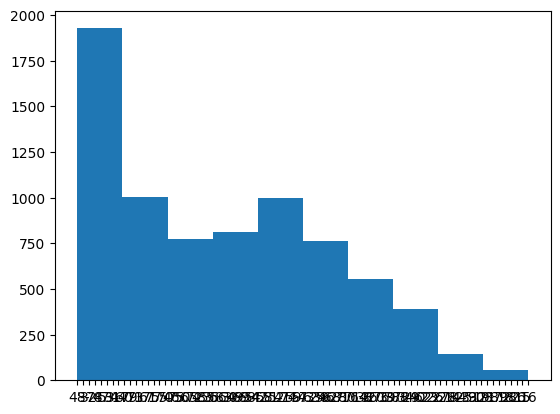

In [4]:
# extarcting the age column
age = clinical_df['age_at_index']
plt.hist(age, bins=10)

In [5]:
def parse_tsv_file(file_path):
    dataframe = pd.read_csv(file_path, delimiter='\t', comment='#')
    dataframe = dataframe[dataframe['gene_id'].str.startswith('ENSG')]
    dataframe = dataframe[['gene_id', 'tpm_unstranded']]
    dataframe = dataframe.set_index('gene_id').T.reset_index(drop=True)
    return dataframe

def build_dataset(folder_path):
    dataframes = []
    folder_path = Path(folder_path)

    if not folder_path.is_dir():
        print(f"Invalid folder path: {folder_path}")
        return None

    tsv_files = list(folder_path.glob("**/*.tsv"))

    if not tsv_files:
        print("No .tsv files found.")
        return None

    for idx, tsv_file in enumerate(tsv_files):
        print(f"Processing file {idx+1}/{len(tsv_files)}: {tsv_file}")
        dataframe = parse_tsv_file(tsv_file)
        if dataframe is not None:
            dataframes.append(dataframe)

    if not dataframes:
        print("No valid dataframes found.")
        return None

    combined_dataframe = pd.concat(dataframes, ignore_index=True)
    return combined_dataframe


In [8]:
data = None
data = build_dataset("data/data-tcga/samples")
print(data)

Processing file 1/8879: data/data-tcga/samples/3419ef02-f1d6-442c-8e4b-97f94540f650/024d8b88-476c-4fda-a343-9a1d0160ed19.rna_seq.augmented_star_gene_counts.tsv
Processing file 2/8879: data/data-tcga/samples/ab989339-de30-48b5-b30d-5d23123aaaee/482876d9-a6fb-4642-acbc-c3e45880e576.rna_seq.augmented_star_gene_counts.tsv
Processing file 3/8879: data/data-tcga/samples/248ac510-a5af-4608-9cdc-5c8673633b82/d23ff3bc-5524-4dca-b0f4-a1561a30566c.rna_seq.augmented_star_gene_counts.tsv
Processing file 4/8879: data/data-tcga/samples/756a1731-8c8d-4d96-8e22-3f382275a48b/17131c68-cbbb-453a-86c2-6688955807e3.rna_seq.augmented_star_gene_counts.tsv
Processing file 5/8879: data/data-tcga/samples/c0be8069-8e65-4441-930a-bb8178445e3b/36532c8b-643c-4271-bb66-06a42e47914d.rna_seq.augmented_star_gene_counts.tsv
Processing file 6/8879: data/data-tcga/samples/1c31bd56-1ce8-4276-a063-064c6d74033a/fddd9f63-f4af-46b9-9627-f69fcff845ed.rna_seq.augmented_star_gene_counts.tsv
Processing file 7/8879: data/data-tcga/s

KeyboardInterrupt: 

In [ ]:
# remove the first column
data = data.iloc[:, 1:]

In [ ]:
print(data)

In [ ]:
data

In [ ]:
def train_xgboost_model(data, clinical_df):
    # Ignore the first column "gene_id"
    features = data.iloc[:, 1:]
    target = clinical_df['age_at_index']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Train an XGBoost regression model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    return model

In [ ]:
print(data.shape)
print(clinical_df.shape)
model = train_xgboost_model(data, clinical_df)

In [ ]:
predictions = model.predict(data)
results = pd.DataFrame({'Actual': clinical_df['age_at_index'], 'Predicted': predictions})
errors = results['Actual'] - results['Predicted']
plt.hist(errors, bins=10)